In [1]:
import os

def count_images_in_subfolders(folder_path):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    image_counts = {}

    for subfolder in subfolders:
        image_files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f)) and f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp', 'tiff'))]
        image_counts[os.path.basename(subfolder)] = len(image_files)
    
    return image_counts

folder_path = r"/kaggle/input/pizza-not-pizza/pizza_not_pizza"
image_counts = count_images_in_subfolders(folder_path)

for subfolder, count in image_counts.items():
    print(f"{subfolder}: {count} images")

not_pizza: 983 images
pizza: 983 images


In [2]:
def get_image_paths_in_subfolders(folder_path):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    image_paths = {}

    for subfolder in subfolders:
        image_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f)) and f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp', 'tiff'))]
        image_paths[os.path.basename(subfolder)] = image_files
    
    return image_paths

In [3]:
folder_path = r"/kaggle/input/pizza-not-pizza/pizza_not_pizza"
image_paths = get_image_paths_in_subfolders(folder_path)

In [4]:
all_img_path = list()
for key, value in image_paths.items():
    all_img_path += value
len(all_img_path)

1966

In [5]:
all_img_path[0], all_img_path[1000]

('/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2374305.jpg',
 '/kaggle/input/pizza-not-pizza/pizza_not_pizza/pizza/2218680.jpg')

In [6]:
label = {
    "pizza" : 0,
    "not_pizza" : 1
}

In [7]:
label2target = {}
for key, value in label.items():
    label2target[value] = key

In [8]:
import cv2
import numpy as np

def create_X_and_Y(all_img_path, target_size = (400,400)):
    X, Y = list(), list()
    
    for path in all_img_path:
        target = path.split("/")[-2]
        Y.append(label[target])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        X.append(img)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [9]:
X, Y = create_X_and_Y(all_img_path)
X.shape, Y.shape

((1966, 400, 400, 3), (1966,))

In [10]:
import random
from matplotlib import pyplot as plt

def show_images(X, Y, num_img = 5):
    random_indices = random.sample(range(len(X)), num_img)
    for index in random_indices:
        print(label2target[Y[index]])
        plt.imshow(X[index])
        plt.axis("off")
        plt.show()

not_pizza


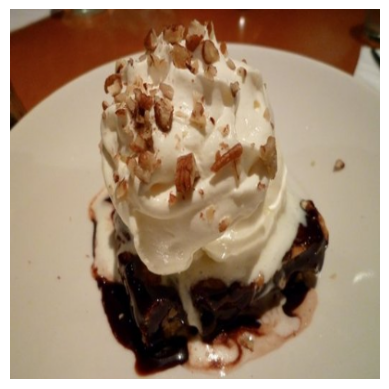

not_pizza


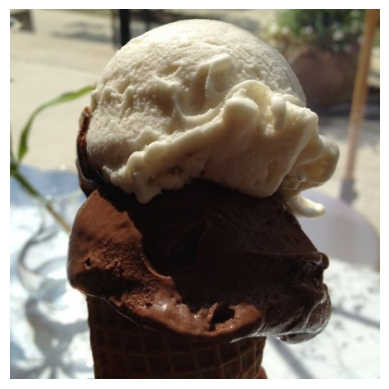

not_pizza


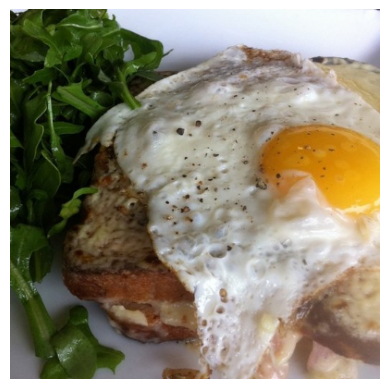

pizza


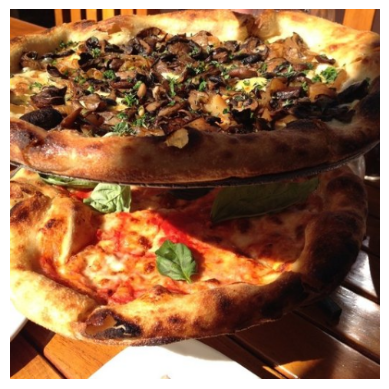

pizza


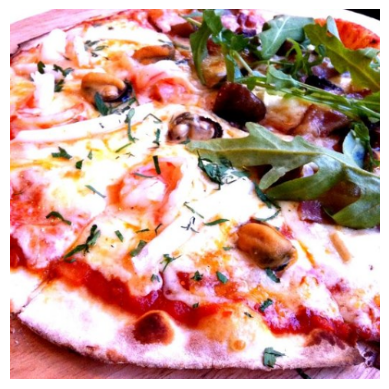

In [11]:
show_images(X, Y)

In [12]:
from keras.utils import to_categorical

num_classes = len(label)
Y_one_hot = to_categorical(Y, num_classes=num_classes)
Y_one_hot.shape

2024-07-08 06:53:44.611395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 06:53:44.611489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 06:53:44.722887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(1966, 2)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y_one_hot, test_size=0.2, random_state=97)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=97)

print(X_train.shape, "   ", Y_train.shape)
print(X_val.shape, "   ", Y_val.shape)
print(X_test.shape, "   ", Y_test.shape)

(1572, 400, 400, 3)     (1572, 2)
(197, 400, 400, 3)     (197, 2)
(197, 400, 400, 3)     (197, 2)


In [14]:
X_train_norm = X_train/255.0
X_val_norm = X_val/255.0
X_test_norm = X_test/255.0

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape

((1572, 400, 400, 3), (197, 400, 400, 3), (197, 400, 400, 3))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization

In [16]:
INPUT_SIZE = (400, 400, 3)

model = Sequential([
    Conv2D(32,(3,3),input_shape=INPUT_SIZE,activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(256,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 197, 197, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 135424)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,667,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,057,970 (34.55 MB)

 Trainable params: 9,057,330 (34.55 MB)

 Non-trainable params: 640 (2.50 KB)

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, Y_train,
                    epochs=500,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping]
                    ,verbose=1)

Epoch 1/500
 1/50 ━━━━━━━━━━━━━━━━━━━━ 5:12 6s/step - accuracy: 0.5938 - loss: 0.5103

W0000 00:00:1720421804.304603     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6853 - loss: 0.7256

W0000 00:00:1720421816.027732     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.6848 - loss: 0.7270 - val_accuracy: 0.5228 - val_loss: 5.7356
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5935 - loss: 0.8430 - val_accuracy: 0.5279 - val_loss: 5.3734
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.6110 - loss: 0.6700 - val_accuracy: 0.5990 - val_loss: 1.5447
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.6760 - loss: 0.5655 - val_accuracy: 0.6396 - val_loss: 0.8602
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.7248 - loss: 0.5256 - val_accuracy: 0.7005 - val_loss: 0.7723
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.7499 - loss: 0.4799 - val_accuracy: 0.6853 - val_loss: 0.7200
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7810 - loss: 0.4744 - val_accuracy: 0.6599 - val_loss: 0.6342
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.7923 - loss: 0.4223 - val_accuracy: 0.807

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7428 - loss: 0.5145
Test Loss: 0.5755420923233032
Test Accuracy: 0.7157360315322876


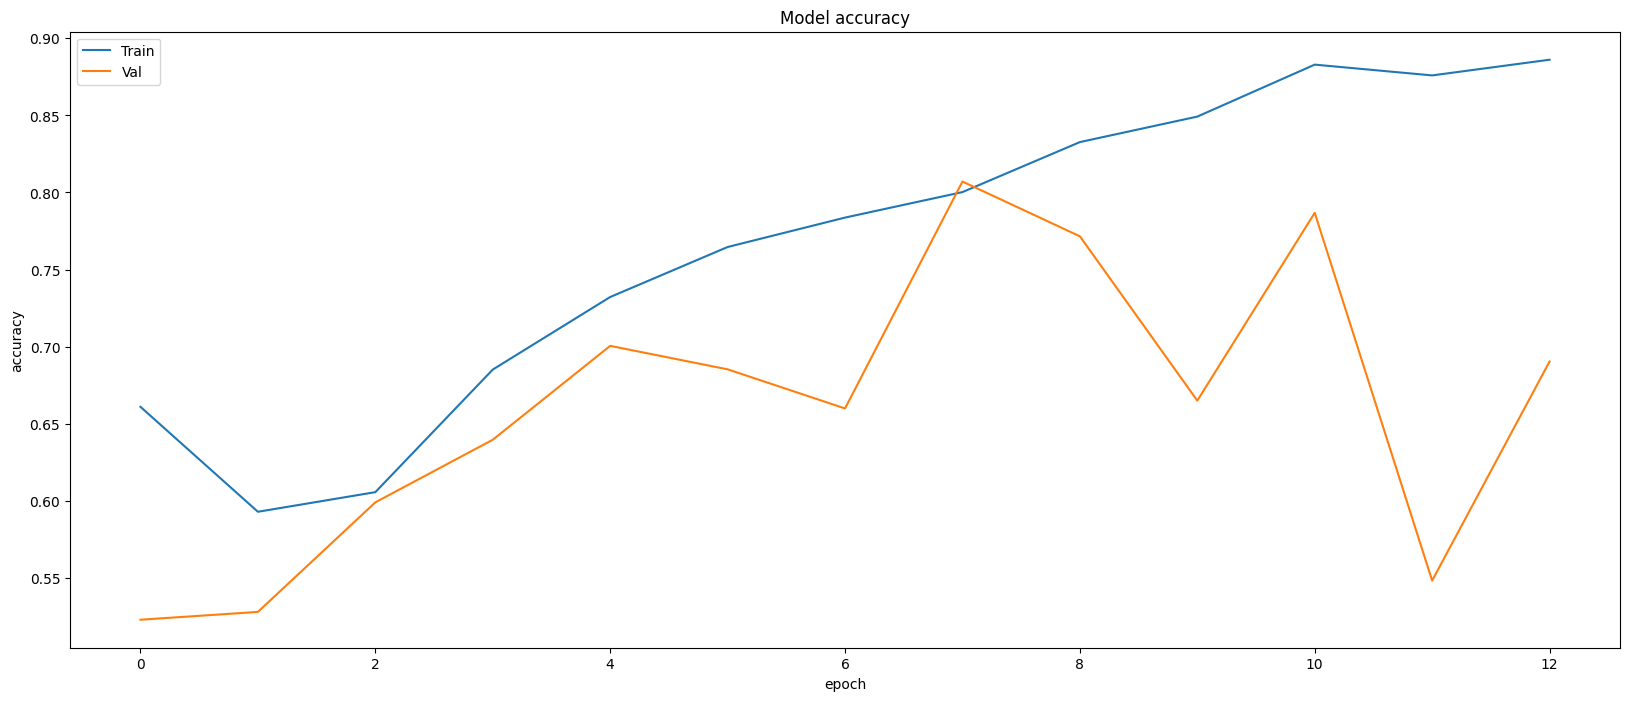

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [26]:
!python --version

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Python 3.10.13


In [27]:
!python3 --version

Python 3.10.13


In [28]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [29]:
dict = unpickle(r"/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1")
len(dict)

4

In [34]:
for key, value in dict.items():
    print(key)

b'batch_label'
b'labels'
b'data'
b'filenames'


In [37]:
type(dict[b'labels'])
len(dict[b'labels'])

10000

In [41]:
dict[b'data'].shape

(10000, 3072)

In [44]:
def get_all_file_paths(folder):
    file_paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [45]:
main_folder = r"/kaggle/input/cifar10-python/cifar-10-batches-py"
all_file_paths = get_all_file_paths(main_folder)

In [49]:
all_file_paths

['/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4',
 '/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html']

KeyError: b'labels'

In [ ]:
from collections import defaultdict